In [41]:
# Book Recommendation PoC Solution (User-Based Collaborative Filtering with User Demographics)
# Language: Python
# IDE: Jupyter Notebook
# Objective: Design a book recommendation system using the provided Kaggle dataset
# Files: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv


# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import pickle
import sqlite3
from datetime import datetime
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

ratings_path = './Inputfiles/Ratings.csv'
books_path = './Inputfiles/Books.csv'
users_path = './Inputfiles/Users.csv'
positive_threshold = 7 #when to ratings count as positive?
min_ratings = 3 # how many ratings to be considered for recommender?

In [42]:
#1. Data preparation
# Ratings, Books
# Load ratings dataset     
ratings = pd.read_csv(ratings_path)

books_cols_to_use = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']

books = pd.read_csv(books_path, usecols=books_cols_to_use, dtype=str)

# Year-of-Publication contains non-numeric values, so we need an additional quality step
# Keep only rows where Year-Of-Publication is a valid 4-digit integer
books = books[books['Year-Of-Publication'].str.fullmatch(r'\d{4}')]

# Convert the column to integer
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

#display(books.head())

In [43]:
#1. Data preparation
# Users
# Load dataset
users = pd.read_csv(users_path)
#display(users.head())
df = pd.DataFrame(users)
#print(df.dtypes)

In [44]:
#1. Data preparation
# Users
# Preprocess users
# Split Location column into City, State, Country
users[['City', 'State', 'Country']] = users['Location'].str.split(',', n=2, expand=True)
users.drop(columns=['Location'], inplace=True)

# Strip whitespace from new columns
users[['City', 'State', 'Country']] = users[['City', 'State', 'Country']].apply(lambda x: x.str.strip())

# Create a copy to avoid SettingWithCopyWarning
users = users.copy()

# Convert Age to Int
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
users['Age'] = users['Age'].astype('Int64')

# Filter users with Age <= 110 or NaN
users = users[users['Age'].isna() | (users['Age'] <= 110)].copy()

# Impute missing Age with median
median_age = users['Age'].median()
users['Age'] = users['Age'].fillna(median_age)

# Display result
#display(users.head())

In [45]:
# 1. Data preparation
# Ratings
# check data types
# df = pd.DataFrame(ratings)
# print(df.dtypes)

In [46]:
# 1. Data preparation
# ratings / preprocess
ratings = ratings.dropna()
ratings = ratings[ratings['Book-Rating'] != 0]  # Remove 0 ratings
ratings['User-ID'] = ratings['User-ID'].astype('category')
ratings['ISBN'] = ratings['ISBN'].astype('category')

# Preprocess books
books = books.dropna(subset=['ISBN', 'Book-Title'])

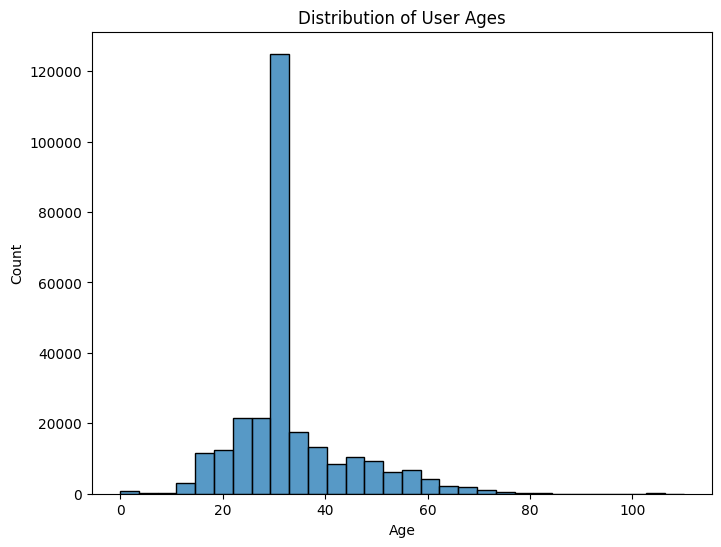

In [47]:
# 2. Data exploration
# Users
# Visualization: Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(users['Age'], bins=30, kde=False)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

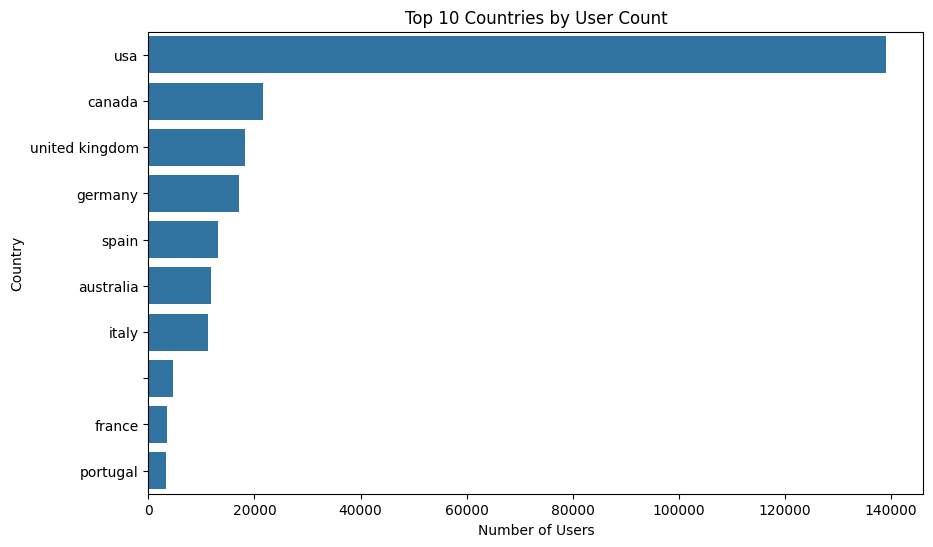

In [48]:
# 2. Data exploration
# Users
# Visualization: Top 10 countries
top_countries = users['Country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by User Count')
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.show()

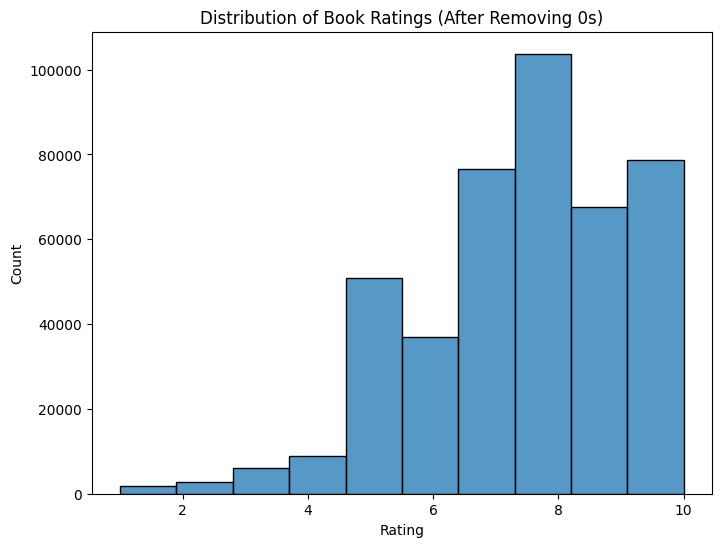

In [49]:
# 2. Data exploration
# Ratings
# Visualization: Histogram of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings['Book-Rating'], bins=10, kde=False)
plt.title('Distribution of Book Ratings (After Removing 0s)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

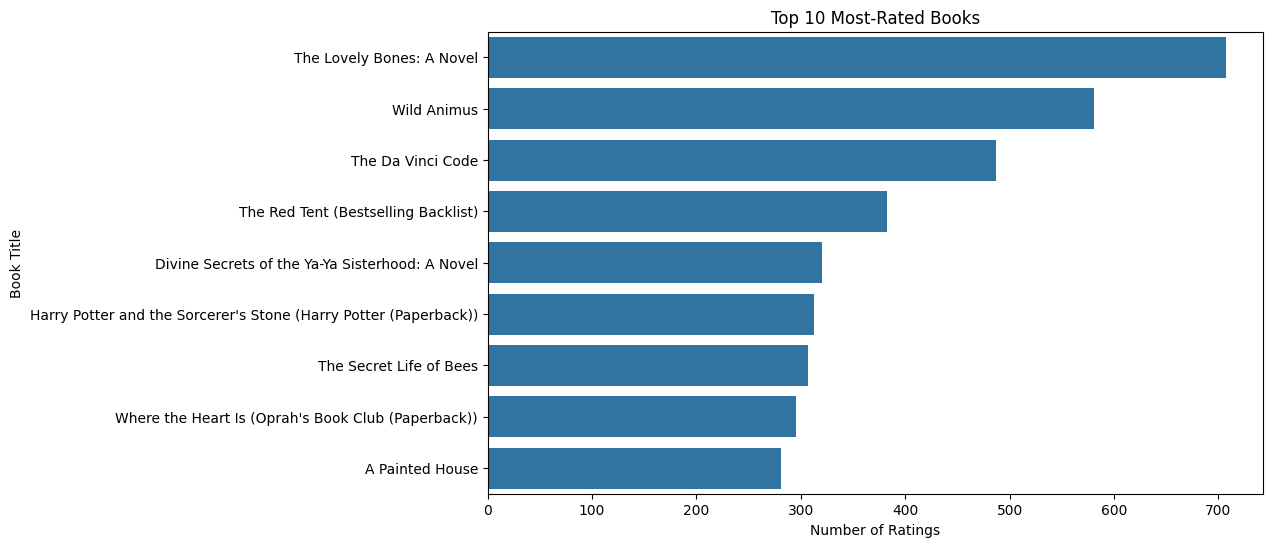

In [50]:
# 2. Data exploration
# Books
# Visualization: Top 10 most-rated books
top_books = ratings['ISBN'].value_counts().head(10)
# Get books with matching ISBNs and their titles
top_books_filtered = books[books['ISBN'].isin(top_books.index)][['ISBN', 'Book-Title']]
# Keep only ISBNs that exist in both top_books and top_books_filtered
valid_isbns = top_books.index[top_books.index.isin(top_books_filtered['ISBN'])]
# Filter top_books and top_books_filtered to valid ISBNs
top_books = top_books[valid_isbns]
top_books_filtered = top_books_filtered[top_books_filtered['ISBN'].isin(valid_isbns)].set_index('ISBN').loc[valid_isbns].reset_index()
# Extract aligned data
isbn_order = top_books_filtered['ISBN']
top_titles = top_books_filtered['Book-Title']
top_counts = top_books.loc[isbn_order].values
plt.figure(figsize=(10, 6))
sns.barplot(x=top_counts, y=top_titles)
plt.title('Top 10 Most-Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()

In [51]:
book_counts = ratings['ISBN'].value_counts()
popular_books = book_counts[book_counts >= 5].index
ratings[(ratings['ISBN'].isin(popular_books)) &
        (ratings['Book-Rating'] >= positive_threshold)
        ].head()

,User-ID,ISBN,Book-Rating
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
28,276754,0684867621,8


In [52]:
# 3. Model Building
# creating a sparse matrix / categorical data to numerical indices


# Encode User-ID and ISBN to indices
user_encoder = LabelEncoder() # note: only users that have ratings will be encluded in the encoder, will treat that later
book_encoder = LabelEncoder()

# Filter books with positive ratings and minimal amount of ratings
book_counts = ratings['ISBN'].value_counts()
popular_books = book_counts[book_counts >= min_ratings].index
filtered_ratings = ratings[(ratings['ISBN'].isin(popular_books)) &
        (ratings['Book-Rating'] >= positive_threshold)]

user_ids = user_encoder.fit_transform(filtered_ratings['User-ID'])
book_ids = book_encoder.fit_transform(filtered_ratings['ISBN'])
ratings_values = filtered_ratings['Book-Rating'].astype(float).values

# Build sparse matrix directly
sparse_matrix = coo_matrix(
    (ratings_values, (user_ids, book_ids))
)

# Compress to csr for efficient row slicing
sparse_matrix = sparse_matrix.tocsr()

# Get index → user-ID mapping
user_indices = pd.Series(user_encoder.inverse_transform(np.arange(len(user_encoder.classes_))))
book_indices = pd.Series(book_encoder.inverse_transform(np.arange(len(book_encoder.classes_))))

#how sparse is the matrix?
sparsity = 100 * (1 - sparse_matrix.count_nonzero() / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))
print(f"Sparsity: {sparsity:.2f}%")

# show example of assigned items
nonzero_user, nonzero_book = sparse_matrix.nonzero()

for i in range(10):  # Nur 10 Beispiele
    u_id = user_indices.iloc[nonzero_user[i]]
    b_id = book_indices.iloc[nonzero_book[i]]
    rating = sparse_matrix[nonzero_user[i], nonzero_book[i]]
    print(f"User {u_id} rated Book {b_id} with {rating}")

Sparsity: 99.99%
User 16 rated Book 0345402871 with 9.0
User 17 rated Book 0425099148 with 7.0
User 19 rated Book 0375759778 with 7.0
User 26 rated Book 0446310786 with 10.0
User 26 rated Book 0449005615 with 9.0
User 32 rated Book 0060168013 with 8.0
User 39 rated Book 0553582909 with 8.0
User 39 rated Book 0671888587 with 7.0
User 42 rated Book 0553582747 with 7.0
User 44 rated Book 0440223571 with 8.0


In [53]:
# 3.a Model Building
# Compute cosine similarity between all users
user_similarity = cosine_similarity(sparse_matrix)

In [54]:
# 3.a Model Building
# user similarity based recommendations

def recommend_books_for_user(real_user_id, sparse_matrix, user_encoder, book_encoder, user_similarity, user_indices, book_indices, books_df, top_books, top_n=10):
    # Ensure books_df index is set to ISBN
    if books_df.index.name != 'ISBN':
        books_df.set_index('ISBN', inplace=True)

    # Check if user ID is known
    if real_user_id not in user_encoder.classes_:
        # Extract top_n ISBNs from top_books (Series index)
        recommended_isbns = top_books.index[:top_n].tolist()
        # Filter ISBNs that exist in books_df
        recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]
        # Lookup titles in books_df
        recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
        # Return DataFrame
        return pd.DataFrame({
            'ISBN': recommended_isbns,
            'Title': recommended_titles
        })
    
    # Convert real ID to matrix index
    target_idx = user_encoder.transform([real_user_id])[0]
    
    # Similarity scores for the user
    similarities = user_similarity[target_idx]
    
    # Exclude the user themself
    other_indices = np.delete(np.arange(len(similarities)), target_idx)
    sorted_similar_idxs = other_indices[np.argsort(similarities[other_indices])[::-1]]
    
    # Get books the user has already rated
    user_rated_books = sparse_matrix[target_idx].nonzero()[1]
    
    # Score accumulation
    scores = {}
    for sim_user_idx in sorted_similar_idxs:
        sim_score = similarities[sim_user_idx]
        sim_user_ratings = sparse_matrix[sim_user_idx]
        for book_idx in sim_user_ratings.nonzero()[1]:
            if book_idx in user_rated_books:
                continue
            if book_idx not in scores:
                scores[book_idx] = 0
            scores[book_idx] += sim_score * sim_user_ratings[0, book_idx]
    
    # Sort by score
    ranked_books = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Convert internal book indices to ISBNs, ensuring they exist in books_df
    recommended_isbns = [book_indices.iloc[idx] for idx, _ in ranked_books if book_indices.iloc[idx] in books_df.index]
    # Lookup titles in books_df
    recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
    
    # If no valid recommendations, fall back to top_books
    if not recommended_isbns:
        recommended_isbns = top_books.index[:top_n].tolist()
        recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]
        recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
    
    return pd.DataFrame({
        'ISBN': recommended_isbns,
        'Title': recommended_titles
    })

In [61]:
# 4.a Test/ Debugging
# Find out some test users with a lot of ratings
positive_matrix = sparse_matrix.multiply(sparse_matrix >= 7)
positive_counts = np.array(positive_matrix.getnnz(axis=1))
top_users = pd.DataFrame({
    'User-ID': user_encoder.inverse_transform(np.arange(len(positive_counts))),
    'PositiveRatingCount': positive_counts
}).query('PositiveRatingCount > 0').sort_values('PositiveRatingCount', ascending=False).head(10)
print(top_users)

       User-ID  PositiveRatingCount
1933     11676                 3524
17036    98391                 1737
26612   153662                  724
40400   235105                  446
2785     16795                  438
16553    95359                  376
35119   204864                  343
44386   257204                  326
6200     35859                  318
18070   104636                  315


In [64]:
# 4.a Test
# call that function

recommendations_df = recommend_books_for_user(
    real_user_id=204864,  
    sparse_matrix=sparse_matrix,
    user_encoder=user_encoder,
    book_encoder=book_encoder,
    user_similarity=user_similarity,
    user_indices=user_indices,
    book_indices=book_indices,
    books_df=books,
    top_books=top_books,
    top_n=10
)

print(recommendations_df)

         ISBN                                              Title
0  0385504209                                  The Da Vinci Code
1  0142001740                            The Secret Life of Bees
2  0452282152                          Girl with a Pearl Earring
3  0446310786                              To Kill a Mockingbird
4  059035342X  Harry Potter and the Sorcerer's Stone (Harry P...
5  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...
6  0671027360                                Angels &amp; Demons
7  0316601950                         The Pilot's Wife : A Novel
8  0743418174                                        Good in Bed
9  043935806X  Harry Potter and the Order of the Phoenix (Boo...


In [65]:
# 3.b Model Building
# solution B: item similarity - could be done with association rules (e.g. apriori) or also cosine based. Decided for the latter

# Transpose the sparse matrix to get item-user matrix
item_user_matrix = sparse_matrix.T  # shape: [n_books, n_users]

# Compute item-to-item cosine similarity
item_similarity = cosine_similarity(item_user_matrix)

In [66]:
# 3.b Model Building
# solution B: item similarity - could be done with association rules (e.g. apriori) or also cosine based. Decided for the latter

# Transpose the sparse matrix to get item-user matrix
item_user_matrix = sparse_matrix.T  # shape: [n_books, n_users]

# Compute item-to-item cosine similarity
item_similarity = cosine_similarity(item_user_matrix)

# Recommend books similar to a given list of ISBNs
def recommend_books_from_cart(isbn_list, book_encoder, book_indices, item_similarity, books_df, top_books, top_n=5):
    # Ensure books_df index is set to ISBN
    if books_df.index.name != 'ISBN':
        books_df.set_index('ISBN', inplace=True)

    # Helper function for fallback to top_books
    def get_top_books_fallback(top_n):
        recommended_isbns = top_books.index[:top_n].tolist()
        recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]
        recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
        return pd.DataFrame({
            'ISBN': recommended_isbns,
            'Title': recommended_titles
        })

    # Encode ISBNs to internal indices
    try:
        item_indices = book_encoder.transform(isbn_list)
    except ValueError as e:
        print("One or more ISBNs not found:", e)
        return get_top_books_fallback(top_n)

    # Sum similarity across all cart items
    similarity_scores = np.sum(item_similarity[item_indices], axis=0)

    # Remove the original cart books from recommendations
    similarity_scores[item_indices] = 0

    # Get top-N recommended indices
    recommended_indices = np.argsort(similarity_scores)[::-1][:top_n]

    # Decode internal indices back to ISBNs
    recommended_isbns = book_indices.iloc[recommended_indices].values

    # Filter ISBNs that exist in books_df
    recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]

    # Lookup titles
    recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []

    # If no valid recommendations, fall back to top_books
    if not recommended_isbns:
        return get_top_books_fallback(top_n)

    return pd.DataFrame({
        'ISBN': recommended_isbns,
        'Title': recommended_titles
    })

In [67]:
# 4.b Test
# call that function
cart = ["0971880107","0446672211"]  # 0439064872 Harry Potter 0446672211 Oprah 0971880107 Wild animal

recommendations_df = recommend_books_from_cart(
    isbn_list=cart,
    book_encoder=book_encoder,
    book_indices=book_indices,
    item_similarity=item_similarity,
    books_df=books,
    top_books=top_books,
    top_n=10
)

print(recommendations_df)

         ISBN                                              Title
0  0684856077                      Tales Of Passion Tales Of Woe
1  1567186610  Celtic Myth &amp; Magick: Harness the Power of...
2  0875421318  Earth, Air, Fire, and Water: More Techniques o...
3  0805066128  Before I Say Goodbye: Recollections and Observ...
4  051759501X  A Rock and a Hard Place: One Boy's Triumphant ...
5  0345440137                            I'm the One That I Want
6  0875420222  How to Uncover Your Past Lives (Llwellyn's How...
7  0875422462  Crystal Healing: The Next Step (Llewellyn's Ne...
8  089281764X  The Heart of Yoga: Developing a Personal Practice
9  0449225119  As Long As Life: Memoirs of a Frontier Woman D...


known bugs / glitches / weaknesses:
* titles sometime have more than a unique isbn - this need to be explored and treated 
* bestsellers like king james bible don't have ratings - possible?
* Filtering books with ≥5 ratings reduces the dataset but may exclude niche books that could be relevant for some users.
* untreatet expections like empty cart
* in cold start scenarios the most rated books are returned, better would be books with >n ratings and then order by avg ratings desc